# Import modules

In [1]:
import os, sys
import cv2
from skimage.util import random_noise
import skvideo.io
import imutils
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.signal import savgol_filter

import tensorflow as tf
import keras
from keras.backend.tensorflow_backend import set_session
from keras.applications import InceptionV3, NASNetMobile, VGG19
from keras.layers import Input, LSTM, Dense, TimeDistributed, Bidirectional, GRU, Dropout, Conv3D, MaxPooling3D, ZeroPadding3D, Flatten
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.utils import multi_gpu_model

from tqdm import tqdm
from glob import glob

from IPython.display import Video

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Using TensorFlow backend.


# Def

In [2]:
def show_im(img):
    plt.figure(figsize=(12, 12))
    plt.imshow(img)
    plt.show()

def read_label(file_path):   
    label=pd.read_csv(file_path)
    label["real"]=label["speed"]

    return label

def crop_image(image) :
    h, w, _ = image.shape
    
    h_bottom = h-int(h*0.10)
    h_top = int(h*0.50)
    
    w_crop_size = int(w*0.15)
    
    return image[h_top:h_bottom, w_crop_size:(w-w_crop_size)]

def crop_or_pad(image, size=(299, 299)) :
        
    image = image.astype(np.float32)
    h, w = image.shape[:2]
    window = (0, 0, h, w)
    scale = 1
    padding = [(0, 0), (0, 0), (0, 0)]

    image_max = max(h, w)
    scale = float(max(size)) / image_max
    image = cv2.resize(image, (int(w * scale), int(h * scale)))

    h, w = image.shape[:2]
    top_pad = (size[1] - h) // 2
    bottom_pad = size[1] - h - top_pad
    left_pad = (size[0] - w) // 2
    right_pad = size[0] - w - left_pad
    padding = [(top_pad, bottom_pad), (left_pad, right_pad), (0, 0)]
    image = np.pad(image, padding, mode='constant', constant_values=0)

    # Fix image normalization
    image /= float(np.nanmax(image))

    return image

def make_graph(true, pred) : 
    
    window_size=25
    idx=range(len(true))
    error=true-pred
    smooth=savgol_filter(pred, window_size, 3)    

    fig, ax = plt.subplots(figsize=(20,10))

    plt.plot(idx, pred, 'bx')
    plt.plot(idx, smooth, 'g.')
    plt.plot(idx, true, 'r.')

    plt.xlabel('frame')
    plt.ylabel('truth')
    plt.title('Predicted')
    plt.grid()
    plt.legend(['Predicted speed', '{} windows average'.format(window_size),'ground truth'], loc='upper right')

    plt.savefig(new_path+"jpg")
    plt.show()
    plt.close()

In [3]:
def Build_model():
    
    model = Sequential()
    input_shape=(16, 112, 112, 3) # l, h, w, c

    # 1st layer group
    model.add(Conv3D(64, (3, 3, 3),  activation='relu', padding='same', name='conv1', input_shape=input_shape))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), padding='valid', name='pool1'))

    # 2nd layer group
    model.add(Conv3D(128, (3, 3, 3), activation='relu', padding='same', name='conv2'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool2'))

    # 3rd layer group
    model.add(Conv3D(256, (3, 3, 3), activation='relu', padding='same', name='conv3a'))
    model.add(Conv3D(256, (3, 3, 3), activation='relu', padding='same', name='conv3b'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool3'))

    # 4th layer group
    model.add(Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='conv4a'))
    model.add(Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='conv4b'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool4'))

    # 5th layer group
    model.add(Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='conv5a'))
    model.add(Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='conv5b'))
    model.add(ZeroPadding3D(padding=((0, 0), (0, 1), (0, 1)), name='zeropad5'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool5'))
    model.add(Flatten())

    # FC layers group
    model.add(Dense(4096, activation='relu', name='fc6'))
    model.add(Dropout(.5))
    model.add(Dense(4096, activation='relu', name='fc7'))
    model.add(Dropout(.5))
    model.add(Dense(1,    activation='linear', name='fc8'))
    
    # Optimizer
    adam = Adam(lr=1e-4)

    # Compile
    model.compile(loss='mse',
                  optimizer=adam,
                  metrics=['mse'])

    # Summary
    model.summary()
    
    return model

# Build Model

In [4]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config = config))

In [5]:
model=Build_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv3D)               (None, 16, 112, 112, 64)  5248      
_________________________________________________________________
pool1 (MaxPooling3D)         (None, 16, 56, 56, 64)    0         
_________________________________________________________________
conv2 (Conv3D)               (None, 16, 56, 56, 128)   221312    
_________________________________________________________________
pool2 (MaxPooling3D)         (None, 8, 28, 28, 128)    0         
_________________________________________________________________
conv3a (Conv3D)              (None, 8, 28, 28, 256)    884992    
_________________________________________________________________
conv3b (Conv3D)      

# Set params

In [6]:
label_df=pd.read_csv("../data_all/190430_only_zero_selected.csv")
label_list = [os.path.join("../data_all/label/", os.path.basename(x)) for x in list(label_df["label"])]
video_all = glob("../data_all/video/choi/*/AlwaysMovie/*.MP4")
video_list = [[y for y in video_all if os.path.basename(x).replace(".csv", ".MP4") in y][0] for x in label_list]

data = pd.DataFrame({"video": video_list,
                     "label": label_list})

In [7]:
df_train, df_test = train_test_split(data, test_size=0.1, random_state=0)

df_train=df_train.reset_index(drop=True)
df_test=df_test.reset_index(drop=True)

In [8]:
MODEL_NAME="ConvLSTM-"
MODEL_DIR="../logs/190507_3d_conv_lstm8/"
MODEL_PATH=os.path.join(MODEL_DIR, MODEL_NAME + 'epoch-{epoch:02d}.h5')

if not os.path.exists(MODEL_DIR) :
    os.makedirs(MODEL_DIR, mode=777, exist_ok=True)

ckpt = ModelCheckpoint(MODEL_PATH, monitor='val_loss', verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                              patience=3, min_lr=1e-4)

tboard = TensorBoard(log_dir=MODEL_DIR, histogram_freq=0,
                     write_graph=True, write_images=True)

callbacks_list = [ckpt, tboard]

# Load model

In [9]:
ckpt_list=glob(os.path.join(MODEL_DIR, "*82.h5"))

if len(ckpt_list) > 0 :
    ckpt_path=ckpt_list[-1]
    print("Loading weight from {}.".format(ckpt_path))
    
    model.load_weights(ckpt_path)
    init_epoch=int(ckpt_path.split("-")[-1].split(".")[0])

else :
    [os.remove(x) for x in glob(os.path.join(MODEL_DIR, "*tfevents*"))]
    init_epoch=0

Loading weight from ../logs/190507_3d_conv_lstm8/ConvLSTM-epoch-82.h5.


# DEV

In [10]:
def load_video(data):
    
    # output
    res_out = {"idx" : [],
               "image_ori" : [],
               "image" : [], 
               "label_true" : []}
    
    # Select Video
    video_path = data['video']
    label_path = data['label']

    # Read Label
    labels = read_label(label_path)

    # Get video info
    cap = cv2.VideoCapture(video_path)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Get frame
    for frame_idx in tqdm(range(length)) :
        
        ret, frame = cap.read()

        if ret :
            # Handling Image
            frame=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            cropped_image = crop_image(frame)
            image = crop_or_pad(cropped_image, size=(112, 112))
            
            label = np.nanmedian([labels['real'][frame_idx]]) 
            
            res_out["idx"].append(frame_idx)
            res_out["image_ori"].append(frame)
            res_out["image"].append(image)
            res_out["label_true"].append(label)
            
    return res_out

In [11]:
def data_loader_valid(data, batch_size, seq_len) :
        
    cur_video_batch=[]
    cur_video_seq=[]
    cur_ori_batch=[]
    cur_label_batch=[]
    cur_label_seq=[]
    cur_idx_batch=[]
    cur_idx_seq=[]

    # Select frame
    for idx in data["idx"][:-seq_len] :
        counter=0
        
        while True :

            image = data["image"][idx+counter]
            image_ori = data["image_ori"][idx+counter]
            label = data["label_true"][idx+counter]

            cur_video_seq.append(image)
            cur_label_seq.append(label)
            cur_idx_seq.append(idx+counter)
            
            counter += 1
            
            if len(cur_video_seq) == seq_len :
                cur_video_batch.append(cur_video_seq)
                cur_ori_batch.append(cv2.resize(image_ori, (1280, 720)))
                cur_label_batch.append([cur_label_seq[-1]])
                cur_idx_batch.append(cur_idx_seq)

                cur_video_seq=[]
                cur_label_seq=[]
                cur_idx_seq=[]

                break

        if len(cur_video_batch) == batch_size :
            yield np.array(cur_video_batch), np.array(cur_label_batch), np.array(cur_idx_batch), np.array(cur_ori_batch)

            cur_video_batch=[]
            cur_label_batch=[]
            cur_idx_batch=[]
            cur_ori_batch=[]

# Eval

In [12]:
def make_res(data) : 
    
    print("Step 1. Load Video.")
    # Prepare data
    res_out = load_video(data=df)
    valid_generator=data_loader_valid(data=res_out, seq_len=timesteps, batch_size=batch_size)

    # Predict
    true_label = []
    pred_label = []
    idx_list = []
    image_list = []

    print("Step 2. Do Inference.")
    for valid_images, valid_labels, valid_idx, valid_ori in tqdm(valid_generator, total=int(len(res_out["idx"])//batch_size)) :
        pred = model.predict(x=valid_images)
        true_label.append(valid_labels)
        pred_label.append(pred)
        idx_list.append(valid_idx)
        image_list.extend(valid_ori)

    true_=np.hstack(np.vstack(true_label))
    pred_=np.hstack(np.vstack(pred_label))
    idx_=np.hstack(np.vstack(idx_list))
    
    res = pd.DataFrame({"true" : true_,
                        "pred" : pred_ })
    
    res.to_csv(new_path+"csv")

    # Report
    print("MSE : {:.3f}".format(mean_squared_error(true_, pred_)))
    make_graph(true_, pred_)

    output_size = (1280, 720)

    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    out = cv2.VideoWriter(new_path+"mp4", fourcc, 30.0, output_size)

    print("Step 3. Write Video.")
    # Make Video
    for v_idx in tqdm(range(len(image_list))) : 
        image = image_list[v_idx]
        true_label = true_[v_idx]
        pred_label = pred_[v_idx]

        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        cv2.putText(image, 'True : {:3.3f}'.format(true_label), (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
        cv2.putText(image, 'Pred : {:3.3f}'.format(pred_label), (10, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
        cv2.putText(image, 'Error: {:3.3f}'.format(np.abs(np.diff([true_label, pred_label]))[0]), (10, 110), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)

        out.write(image.astype(np.uint8))
    out.release()

  0%|          | 0/5400 [00:00<?, ?it/s]

./res_out6_2/res_alwa_20190404_120002_F.
Step 1. Load Video.


  0%|          | 0/675 [00:00<?, ?it/s]

Step 2. Do Inference.


100%|█████████▉| 673/675 [01:57<00:00,  5.75it/s]


MSE : 7.499


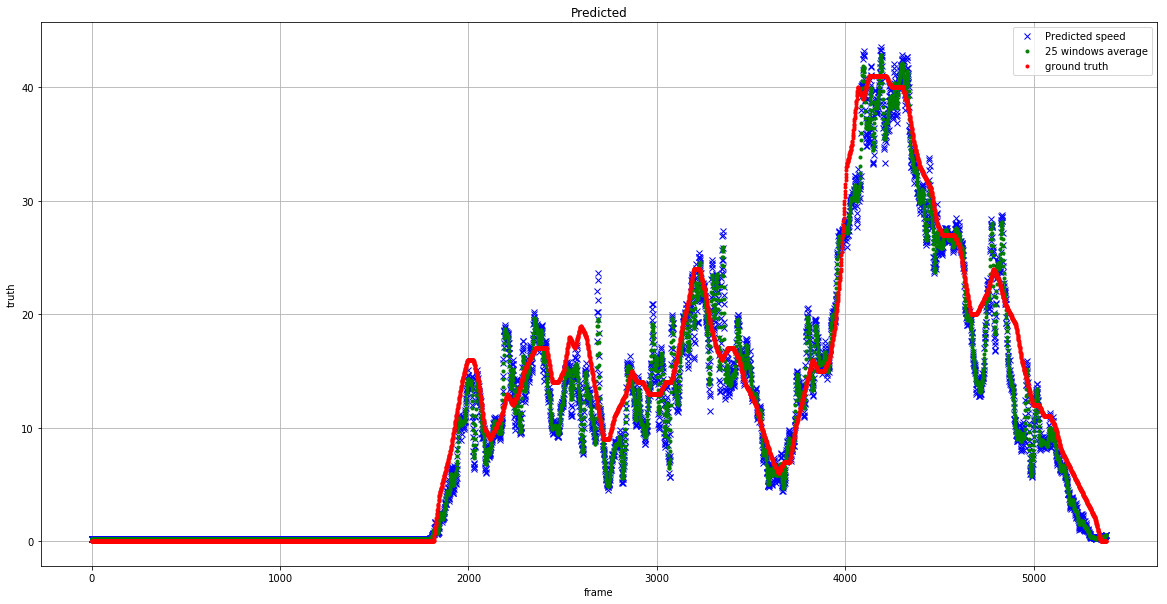

  0%|          | 6/5384 [00:00<01:37, 55.27it/s]

Step 3. Write Video.


  0%|          | 0/5400 [00:00<?, ?it/s]

./res_out6_2/res_alwa_20190415_083519_F.
Step 1. Load Video.


  0%|          | 1/675 [00:00<02:12,  5.08it/s]

Step 2. Do Inference.


100%|█████████▉| 673/675 [01:54<00:00,  5.89it/s]


MSE : 26.635


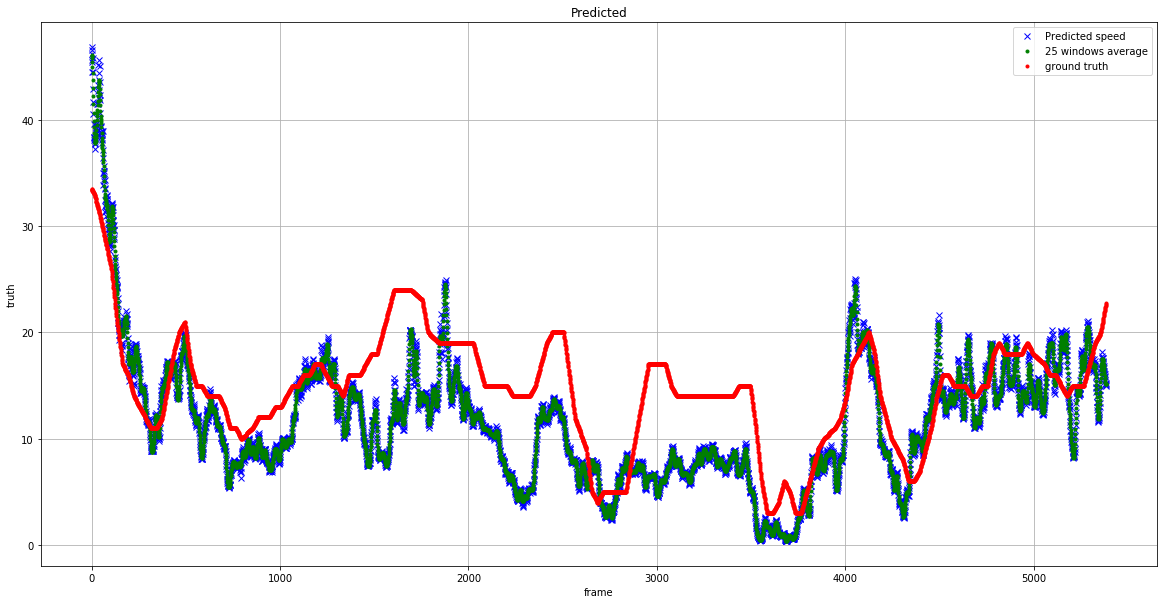

  0%|          | 7/5384 [00:00<01:17, 69.25it/s]

Step 3. Write Video.


  0%|          | 0/5400 [00:00<?, ?it/s]

./res_out6_2/res_alwa_20190405_190650_F.
Step 1. Load Video.


  0%|          | 1/675 [00:00<01:53,  5.96it/s]

Step 2. Do Inference.


100%|█████████▉| 673/675 [01:48<00:00,  6.22it/s]


MSE : 110.760


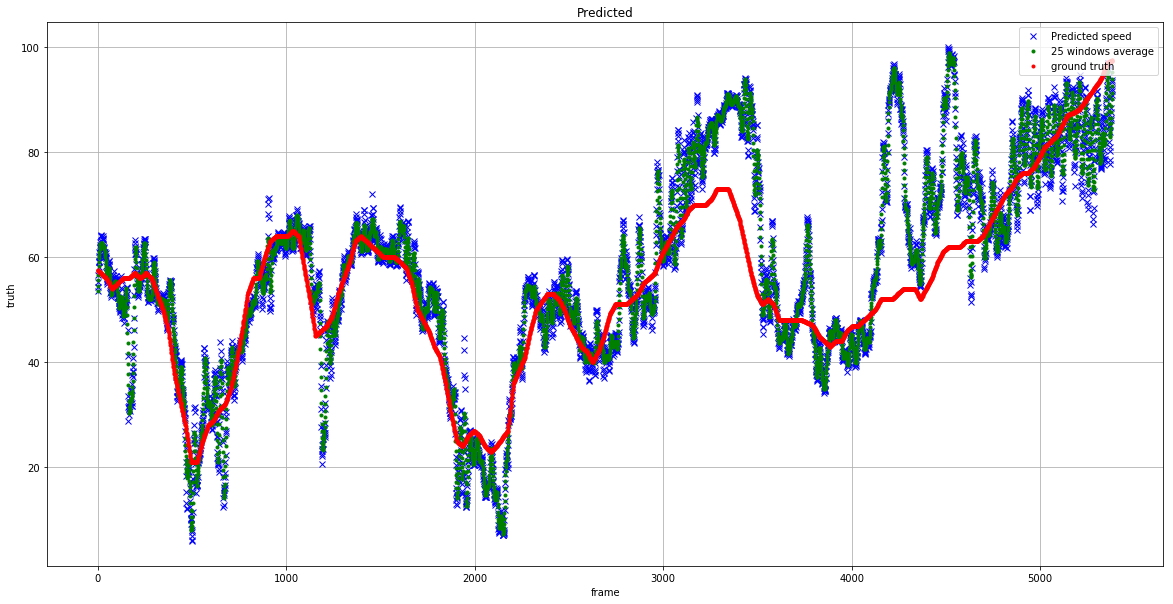

  0%|          | 8/5384 [00:00<01:14, 71.89it/s]

Step 3. Write Video.


  0%|          | 0/5400 [00:00<?, ?it/s]

./res_out6_2/res_alwa_20190404_110322_F.
Step 1. Load Video.


  0%|          | 0/675 [00:00<?, ?it/s]

Step 2. Do Inference.


100%|█████████▉| 673/675 [01:48<00:00,  6.22it/s]


MSE : 10.418


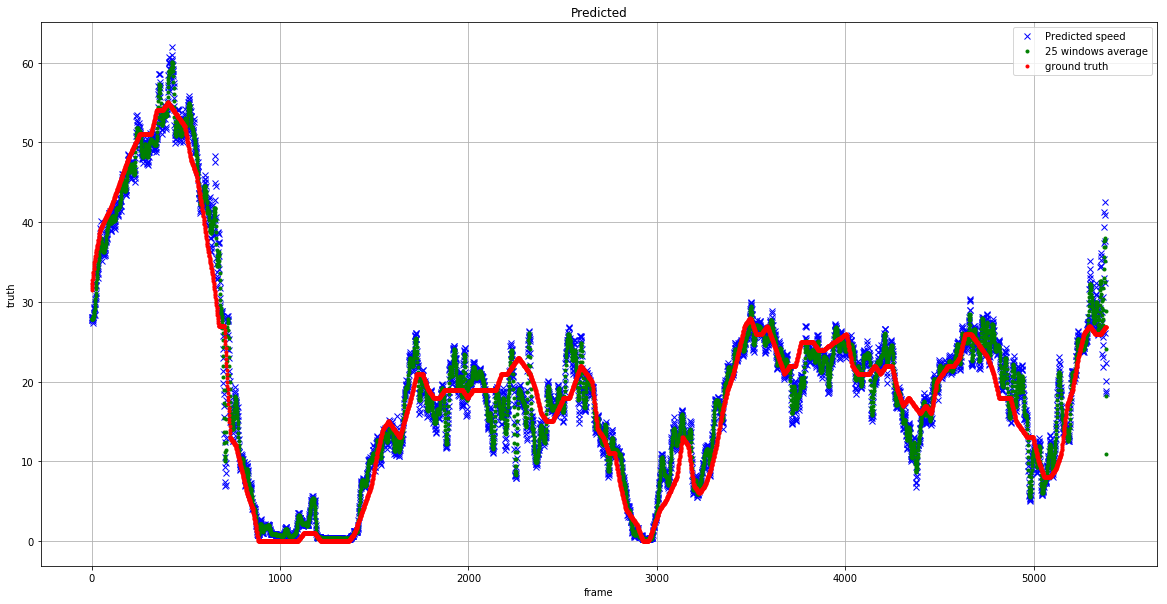

  0%|          | 6/5384 [00:00<01:42, 52.42it/s]

Step 3. Write Video.


  0%|          | 0/5400 [00:00<?, ?it/s]

./res_out6_2/res_alwa_20190418_122605_F.
Step 1. Load Video.


  0%|          | 1/675 [00:00<02:06,  5.33it/s]

Step 2. Do Inference.


100%|█████████▉| 673/675 [01:47<00:00,  6.27it/s]


MSE : 45.719


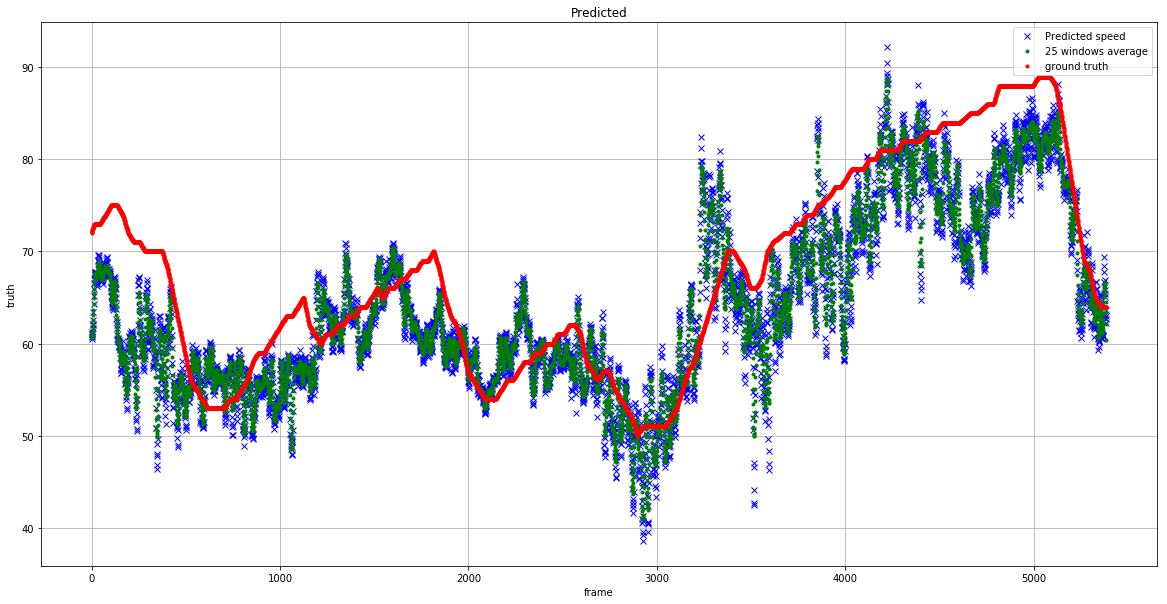

  0%|          | 6/5384 [00:00<01:39, 53.89it/s]

Step 3. Write Video.


  0%|          | 0/5400 [00:00<?, ?it/s]

./res_out6_2/res_alwa_20190415_181248_F.
Step 1. Load Video.


  0%|          | 0/675 [00:00<?, ?it/s]

Step 2. Do Inference.


100%|█████████▉| 673/675 [01:46<00:00,  6.29it/s]


MSE : 15.142


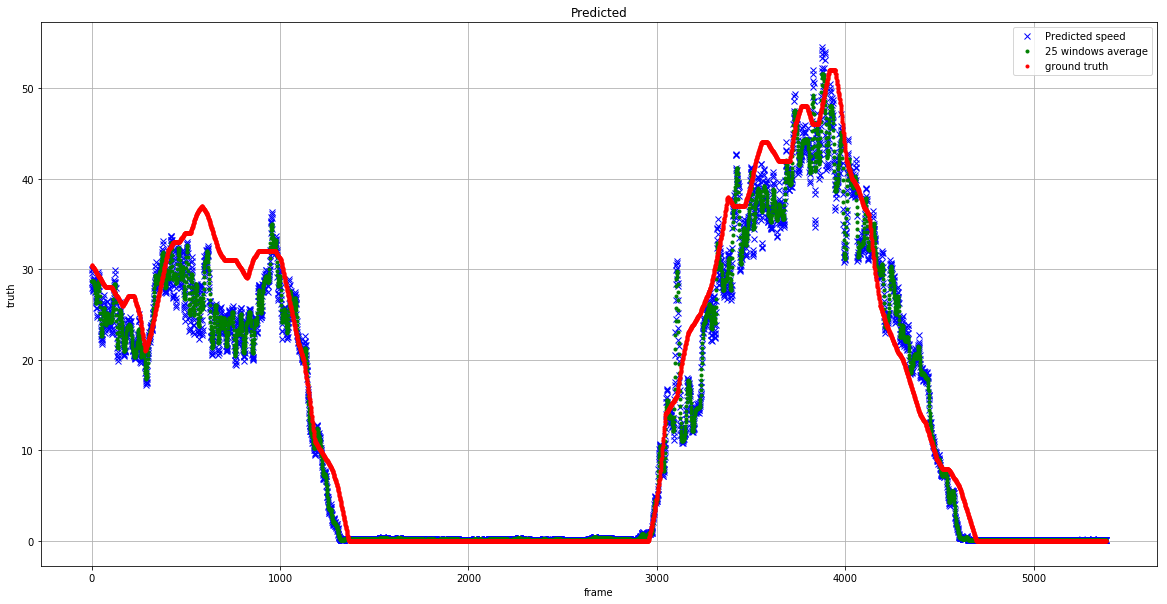

  0%|          | 7/5384 [00:00<01:23, 64.18it/s]

Step 3. Write Video.


  0%|          | 0/5400 [00:00<?, ?it/s]

./res_out6_2/res_alwa_20190416_174216_F.
Step 1. Load Video.


  0%|          | 0/675 [00:00<?, ?it/s]

Step 2. Do Inference.


100%|█████████▉| 673/675 [01:50<00:00,  6.10it/s]


MSE : 36.164


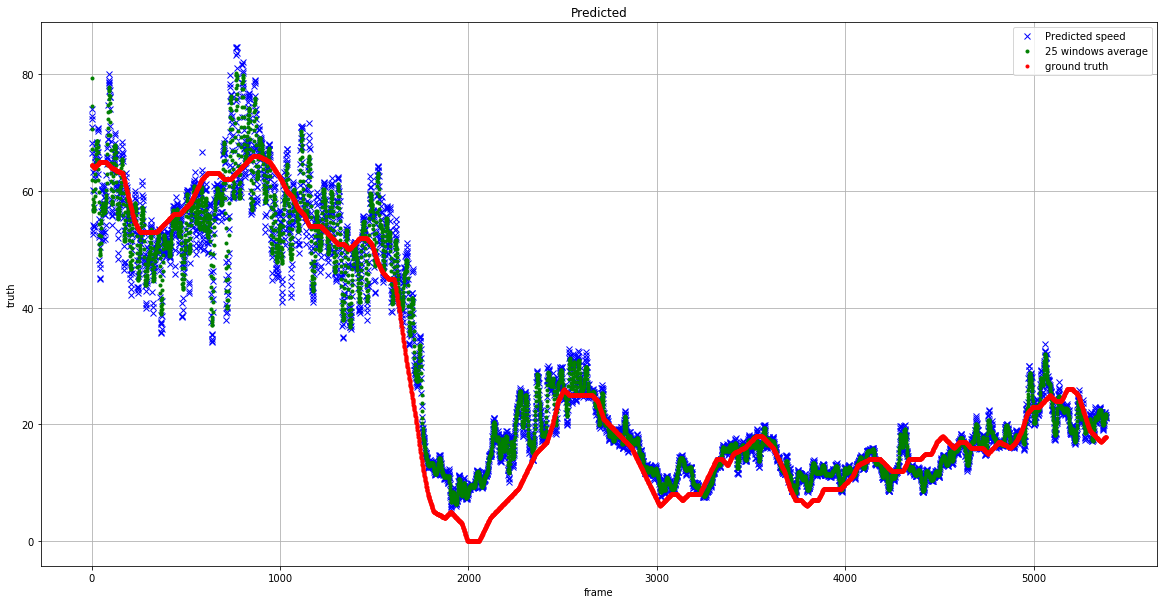

  0%|          | 6/5384 [00:00<01:38, 54.51it/s]

Step 3. Write Video.


  0%|          | 0/5400 [00:00<?, ?it/s]

./res_out6_2/res_alwa_20190416_181217_F.
Step 1. Load Video.


  0%|          | 0/675 [00:00<?, ?it/s]

Step 2. Do Inference.


100%|█████████▉| 673/675 [01:52<00:00,  6.01it/s]


MSE : 19.521


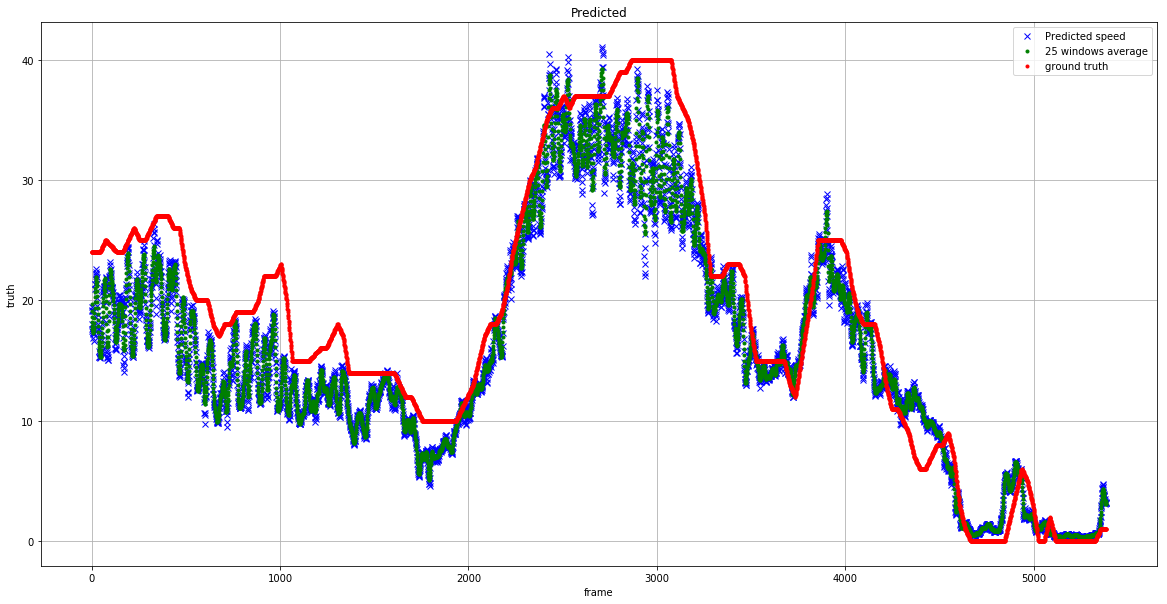

  0%|          | 7/5384 [00:00<01:28, 60.81it/s]

Step 3. Write Video.


  0%|          | 0/5400 [00:00<?, ?it/s]

./res_out6_2/res_alwa_20190415_184851_F.
Step 1. Load Video.


  0%|          | 1/675 [00:00<02:06,  5.35it/s]

Step 2. Do Inference.


100%|█████████▉| 673/675 [01:48<00:00,  6.23it/s]


MSE : 10.338


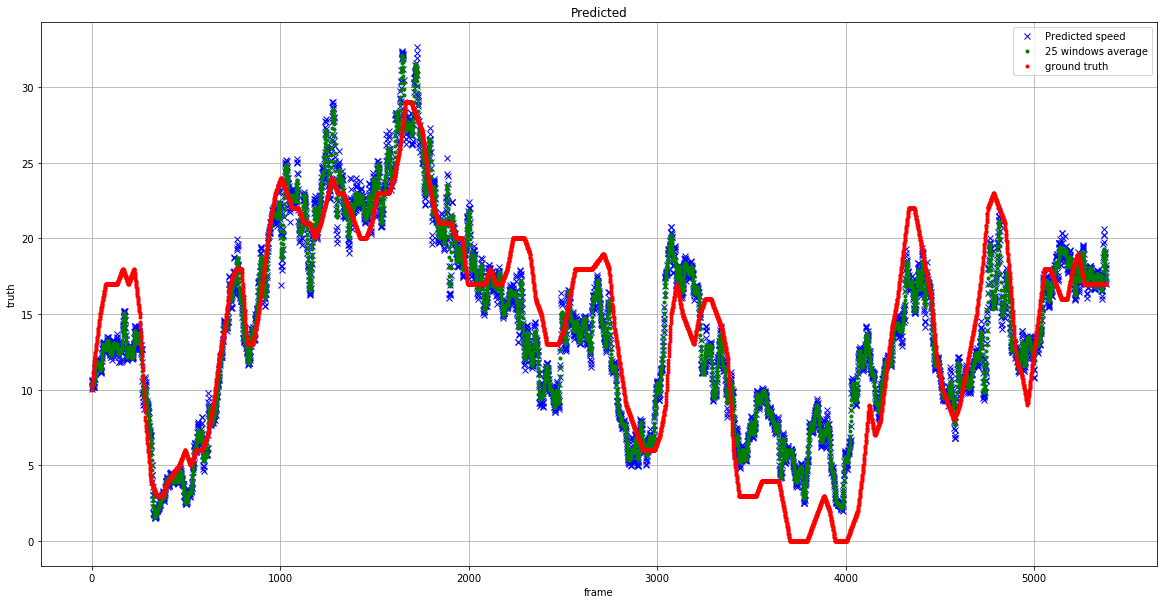

  0%|          | 7/5384 [00:00<01:23, 64.19it/s]

Step 3. Write Video.


  0%|          | 0/5400 [00:00<?, ?it/s]

./res_out6_2/res_alwa_20190417_174716_F.
Step 1. Load Video.


  0%|          | 1/675 [00:00<02:09,  5.21it/s]

Step 2. Do Inference.


100%|█████████▉| 673/675 [01:48<00:00,  6.20it/s]


MSE : 29.105


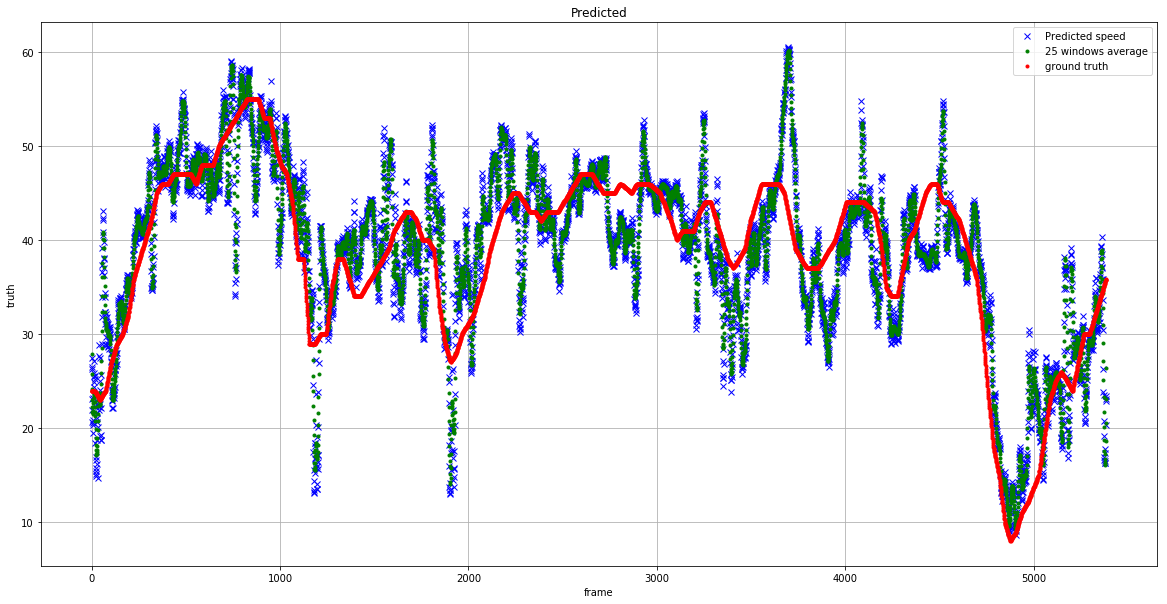

  0%|          | 5/5384 [00:00<02:02, 43.83it/s]

Step 3. Write Video.


  0%|          | 0/5400 [00:00<?, ?it/s]

./res_out6_2/res_alwa_20190405_210056_F.
Step 1. Load Video.


  0%|          | 1/675 [00:00<02:13,  5.06it/s]

Step 2. Do Inference.


100%|█████████▉| 673/675 [01:46<00:00,  6.31it/s]


MSE : 62.625


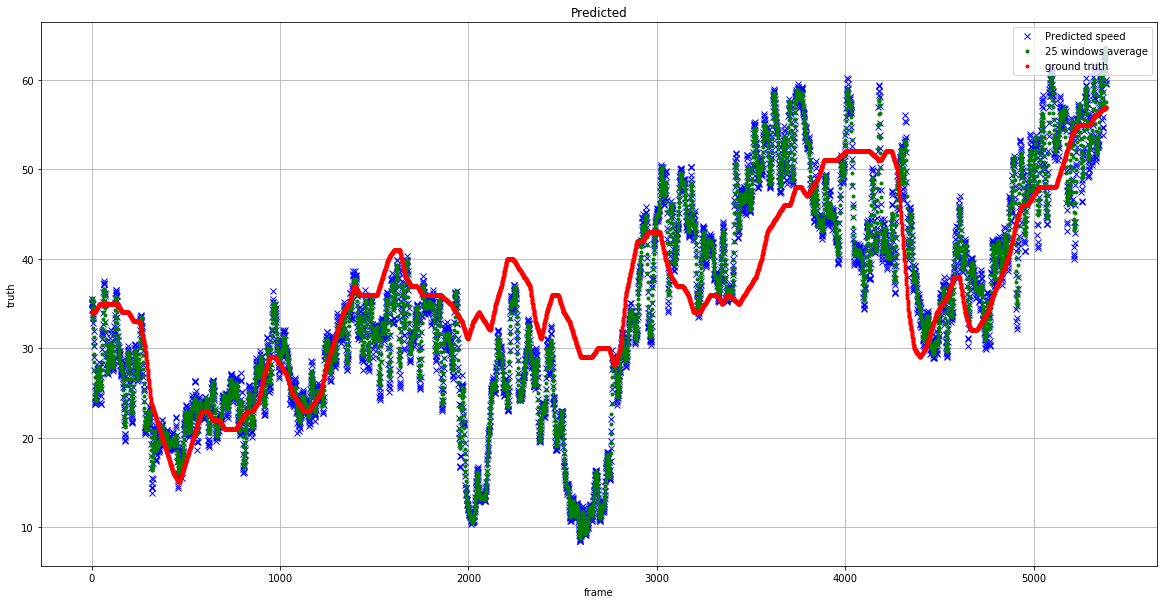

  0%|          | 6/5384 [00:00<01:38, 54.85it/s]

Step 3. Write Video.


  0%|          | 0/5400 [00:00<?, ?it/s]

./res_out6_2/res_alwa_20190417_175917_F.
Step 1. Load Video.


  0%|          | 1/675 [00:00<02:11,  5.12it/s]

Step 2. Do Inference.


100%|█████████▉| 673/675 [01:47<00:00,  6.24it/s]


MSE : 199.793


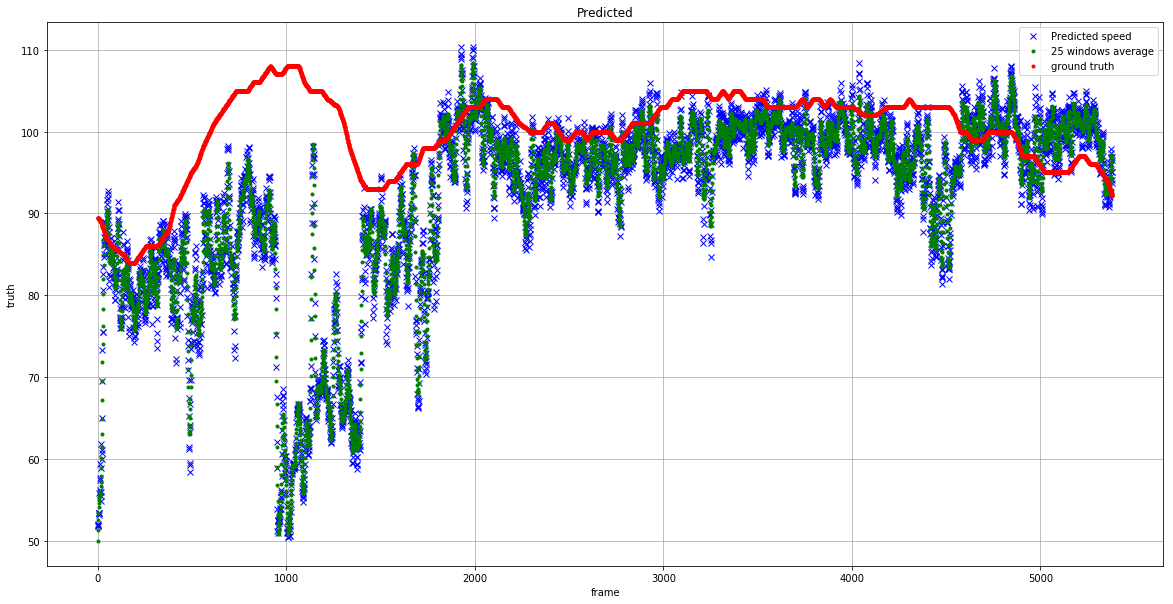

  0%|          | 7/5384 [00:00<01:19, 67.99it/s]

Step 3. Write Video.


  0%|          | 0/5400 [00:00<?, ?it/s]

./res_out6_2/res_alwa_20190410_105551_F.
Step 1. Load Video.


  0%|          | 1/675 [00:00<02:11,  5.12it/s]

Step 2. Do Inference.


100%|█████████▉| 673/675 [01:44<00:00,  6.47it/s]


MSE : 13.576


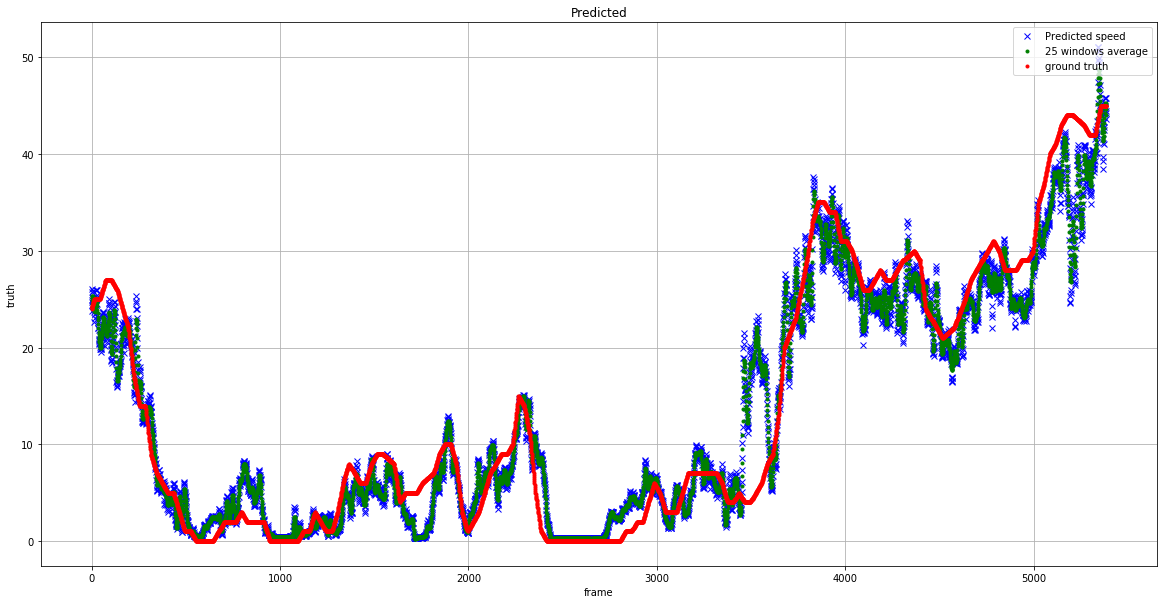

  0%|          | 6/5384 [00:00<01:29, 59.80it/s]

Step 3. Write Video.


  0%|          | 0/5400 [00:00<?, ?it/s]

./res_out6_2/res_alwa_20190418_131836_F.
Step 1. Load Video.


  0%|          | 1/675 [00:00<02:05,  5.39it/s]

Step 2. Do Inference.


100%|█████████▉| 673/675 [01:45<00:00,  6.41it/s]


MSE : 23.549


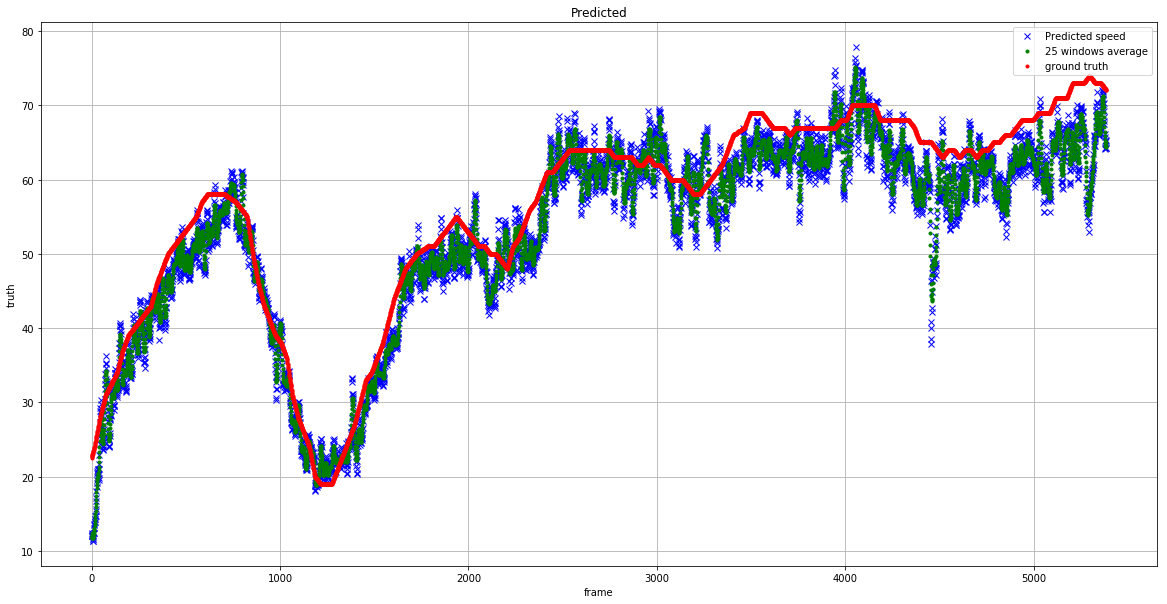

  0%|          | 7/5384 [00:00<01:17, 69.48it/s]

Step 3. Write Video.


  0%|          | 0/5400 [00:00<?, ?it/s]

./res_out6_2/res_alwa_20190415_190952_F.
Step 1. Load Video.


  0%|          | 0/675 [00:00<?, ?it/s]

Step 2. Do Inference.


100%|█████████▉| 673/675 [01:43<00:00,  6.48it/s]


MSE : 18.664


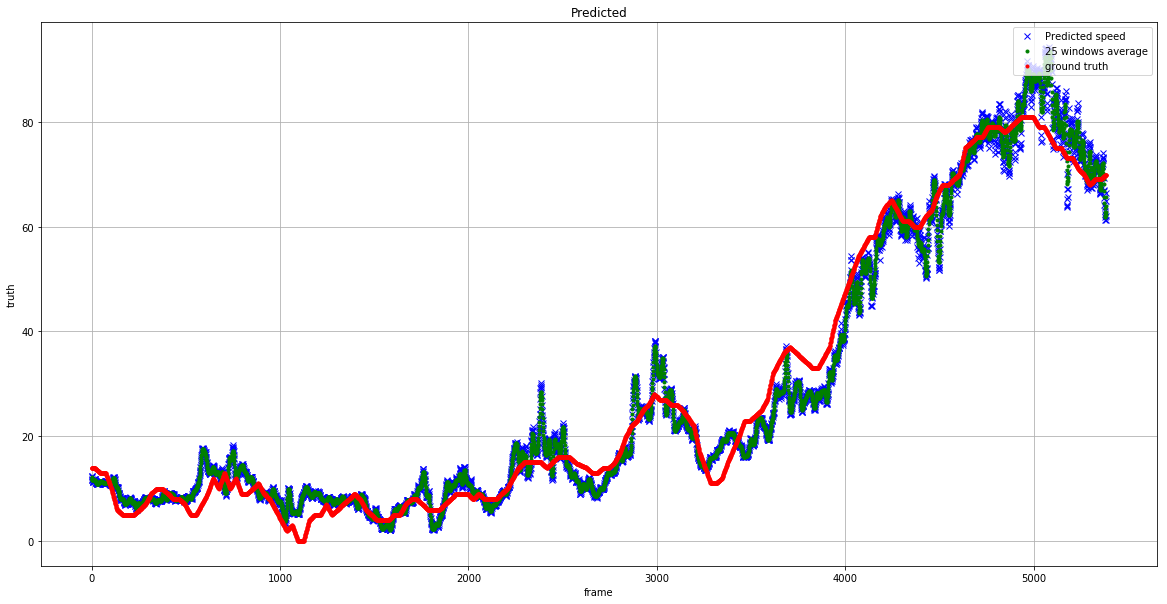

  0%|          | 9/5384 [00:00<01:04, 83.64it/s]

Step 3. Write Video.


  0%|          | 0/5400 [00:00<?, ?it/s]

./res_out6_2/res_alwa_20190415_182449_F.
Step 1. Load Video.


  0%|          | 0/675 [00:00<?, ?it/s]

Step 2. Do Inference.


100%|█████████▉| 673/675 [01:47<00:00,  6.25it/s]


MSE : 42.035


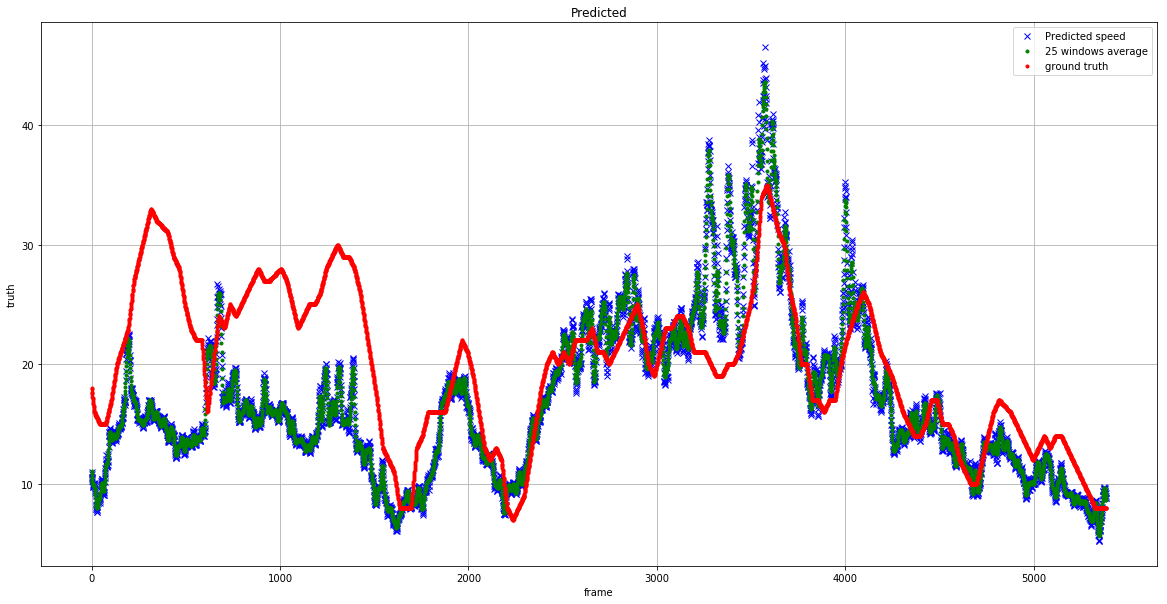

  0%|          | 9/5384 [00:00<01:05, 81.88it/s]

Step 3. Write Video.


  0%|          | 0/5400 [00:00<?, ?it/s]

./res_out6_2/res_alwa_20190418_212014_F.
Step 1. Load Video.


  0%|          | 0/675 [00:00<?, ?it/s]

Step 2. Do Inference.


100%|█████████▉| 673/675 [01:47<00:00,  6.24it/s]


MSE : 106.599


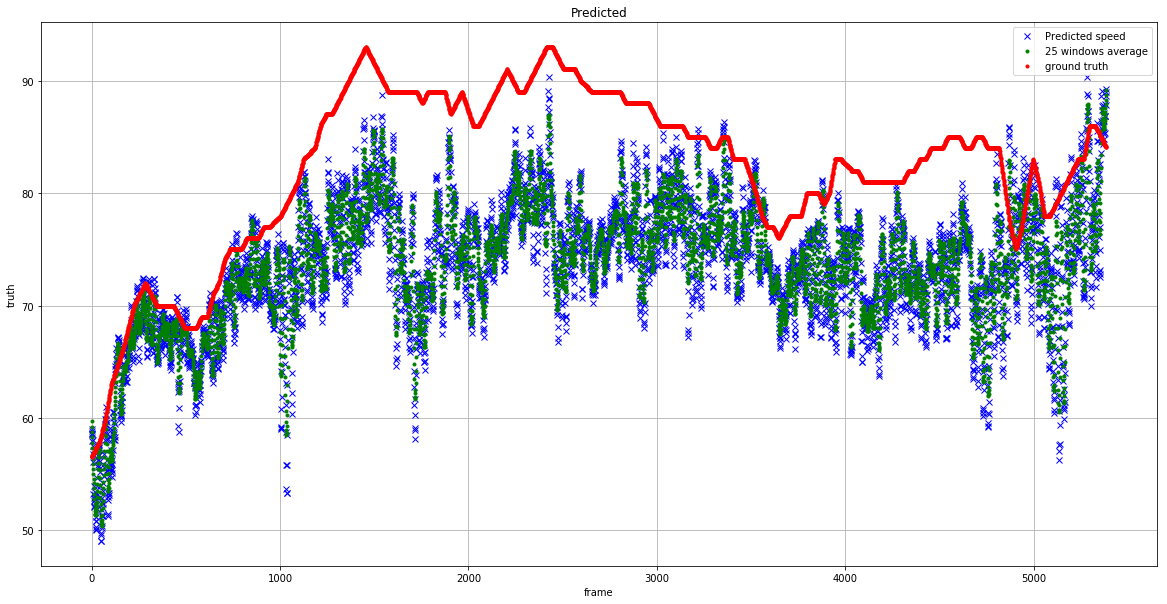

  0%|          | 7/5384 [00:00<01:26, 61.83it/s]

Step 3. Write Video.


  0%|          | 0/5400 [00:00<?, ?it/s]

./res_out6_2/res_alwa_20190405_194252_F.
Step 1. Load Video.


  0%|          | 1/675 [00:00<02:10,  5.17it/s]

Step 2. Do Inference.


100%|█████████▉| 673/675 [01:49<00:00,  6.15it/s]


MSE : 23.132


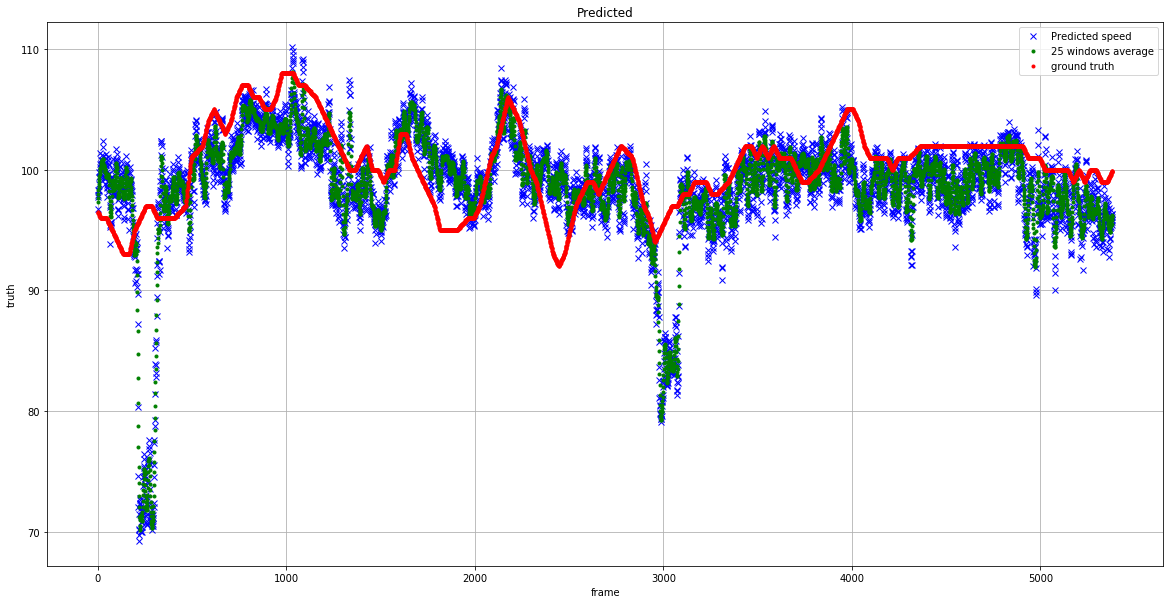

  0%|          | 8/5384 [00:00<01:07, 79.10it/s]

Step 3. Write Video.


  0%|          | 0/5400 [00:00<?, ?it/s]

./res_out6_2/res_alwa_20190413_161426_F.
Step 1. Load Video.


  0%|          | 0/675 [00:00<?, ?it/s]

Step 2. Do Inference.


100%|█████████▉| 673/675 [01:48<00:00,  6.20it/s]


MSE : 7.538


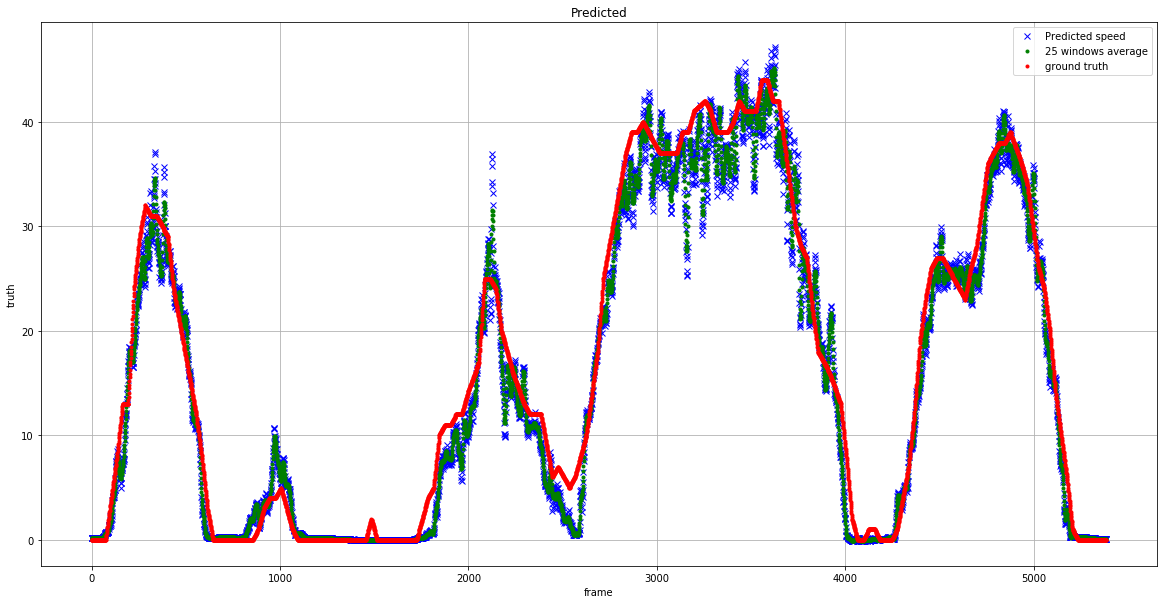

  0%|          | 7/5384 [00:00<01:21, 66.29it/s]

Step 3. Write Video.


  0%|          | 0/5400 [00:00<?, ?it/s]

./res_out6_2/res_alwa_20190404_145539_F.
Step 1. Load Video.


  0%|          | 1/675 [00:00<02:08,  5.24it/s]

Step 2. Do Inference.


100%|█████████▉| 673/675 [01:51<00:00,  6.02it/s]


MSE : 14.469


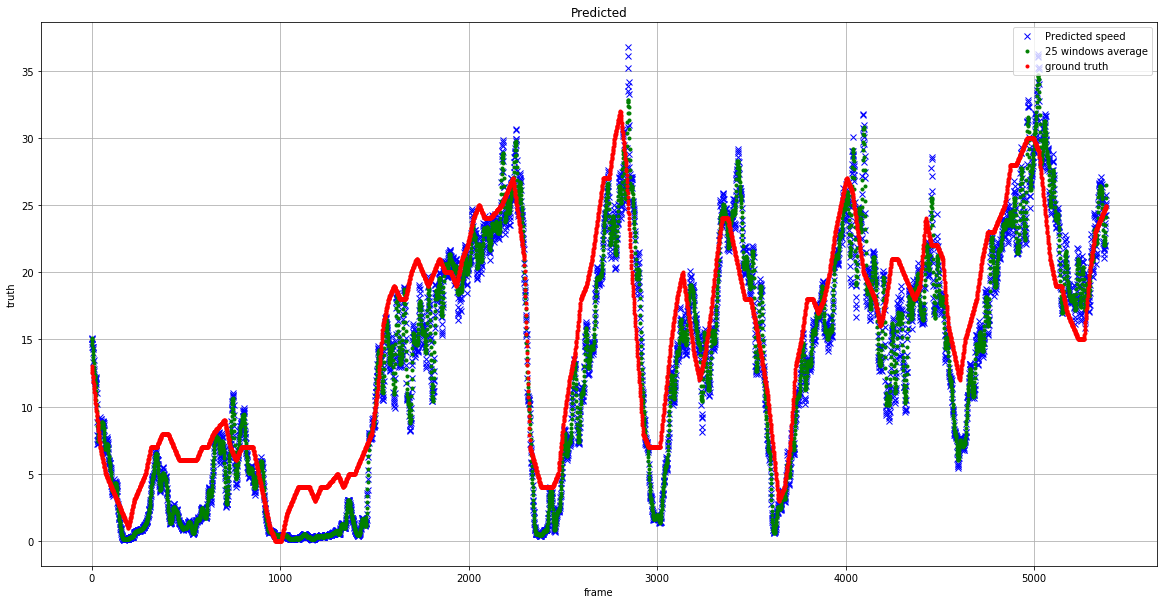

  0%|          | 7/5384 [00:00<01:20, 67.02it/s]

Step 3. Write Video.


  0%|          | 0/5400 [00:00<?, ?it/s]

./res_out6_2/res_alwa_20190417_192321_F.
Step 1. Load Video.


  0%|          | 1/675 [00:00<02:01,  5.55it/s]

Step 2. Do Inference.


100%|█████████▉| 673/675 [01:51<00:00,  6.03it/s]


MSE : 25.694


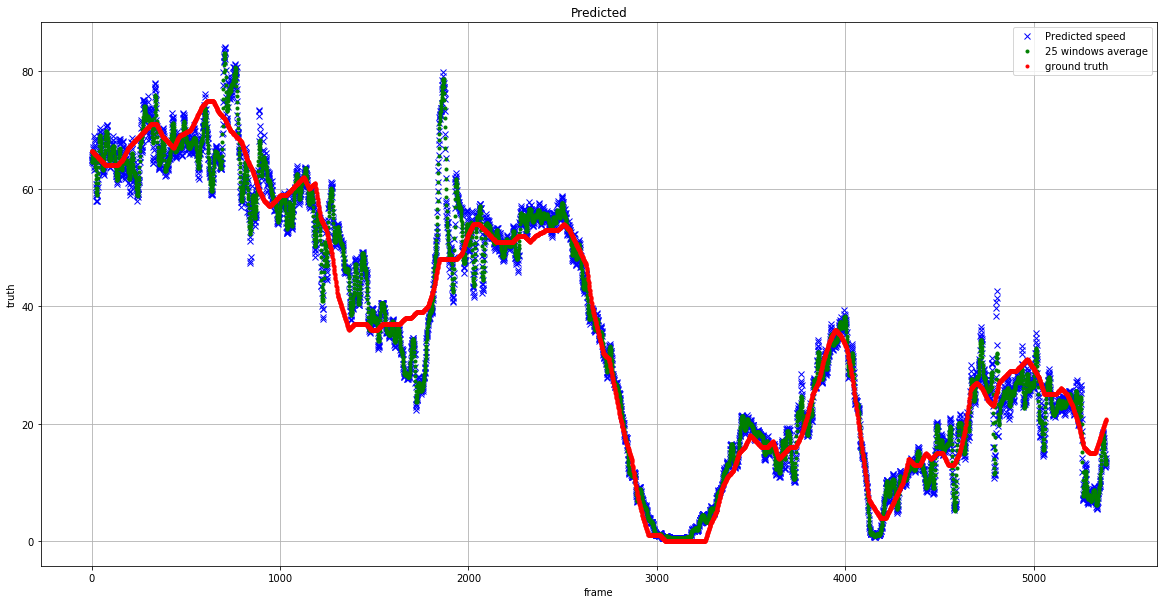

  0%|          | 7/5384 [00:00<01:20, 67.04it/s]

Step 3. Write Video.


100%|██████████| 5384/5384 [01:27<00:00, 61.70it/s]


In [13]:
timesteps=16
batch_size=8

for idx in df_test.index :
    df=df_test.iloc[idx]
    
    new_path = "./res_out6_2/res_"+os.path.basename(df["video"])[:-3]
    print(new_path)
    make_res(df)

---